In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 57.0 MB/s eta 0:00:00


In [2]:

import sys,os
from google.colab import drive

drive.mount('/content/drive')

path_train_module = r'/content/drive/MyDrive/Vision Project/for_github/dataset_discussion'
sys.path.append(path_train_module)

from dataset_analysis_module import * # Do not try this at home
root_path_data = '/content/drive/MyDrive/Vision Project/data_cityscape'

Mounted at /content/drive


In [3]:
train_loaders,train_datasets = load_data_loaders_and_datasets("train",partitions=8,batch_size=8)
val_loaders,val_datasets = load_data_loaders_and_datasets("val",partitions=4,batch_size=8)


[Train] Partition 1 - Images: torch.Size([372, 3, 1024, 2048]), Annotations: torch.Size([372, 1024, 2048])
[Train] Partition 2 - Images: torch.Size([372, 3, 1024, 2048]), Annotations: torch.Size([372, 1024, 2048])
[Train] Partition 3 - Images: torch.Size([372, 3, 1024, 2048]), Annotations: torch.Size([372, 1024, 2048])
[Train] Partition 4 - Images: torch.Size([372, 3, 1024, 2048]), Annotations: torch.Size([372, 1024, 2048])
[Train] Partition 5 - Images: torch.Size([372, 3, 1024, 2048]), Annotations: torch.Size([372, 1024, 2048])
[Train] Partition 6 - Images: torch.Size([372, 3, 1024, 2048]), Annotations: torch.Size([372, 1024, 2048])
[Train] Partition 7 - Images: torch.Size([372, 3, 1024, 2048]), Annotations: torch.Size([372, 1024, 2048])
[Train] Partition 8 - Images: torch.Size([371, 3, 1024, 2048]), Annotations: torch.Size([371, 1024, 2048])
[Train Loader] Partition 1 - 372 samples
[Train Loader] Partition 2 - 372 samples
[Train Loader] Partition 3 - 372 samples
[Train Loader] Partit

In [ ]:
train_datasets_getitem_0 = train_datasets[0].__getitem__(0)

First lets demoinstrate an example of an instance annotated image from the cityscapes dataset. Each image is 1920x1080 RGB.

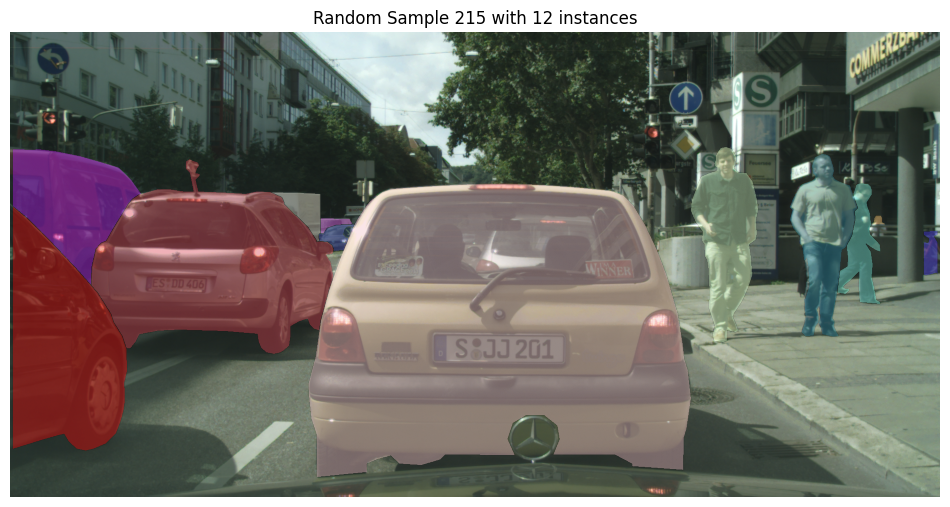

In [ ]:
visualize_random_sample_with_masks_from_dataset(train_datasets[0])

Now lets launch the stats function to collec important in the dataset. We use first training partition for this.

In [7]:

stats = analyze_dataset(train_datasets[0], small_thresh=32*32, medium_thresh=96*96)

Analyzing dataset...

=== DATASET ANALYSIS ===
Total objects: 5448
Total images processed: 372
Average objects per image: 14.65

=== SIZE DISTRIBUTION ===
Small objects (≤32x32px): 1302 (23.9%)
Medium objects (32-96px): 2333 (42.8%)
Large objects (>96x96px): 1813 (33.3%)

=== OBJECT DIMENSIONS ===
Area stats - Mean: 21324.0, Median: 3912.5, Std: 50115.5
Width stats - Mean: 98.1, Median: 56.0, Min: 3.0, Max: 925.0
Height stats - Mean: 113.4, Median: 71.0, Min: 1.0, Max: 911.0
Aspect ratio stats - Mean: 1.03, Median: 0.88, Min: 0.07, Max: 14.00

=== CLASS DISTRIBUTION ===
car            :   3177 ( 58.3%)
person         :   1630 ( 29.9%)
bicycle        :    215 (  3.9%)
truck          :    138 (  2.5%)
rider          :    126 (  2.3%)
motorcycle     :    109 (  2.0%)
bus            :     37 (  0.7%)
train          :     16 (  0.3%)

=== SMALL OBJECT ANALYSIS ===
Small object dimensions:
  Width: 19.5±10.2 (min: 3.0, max: 84.0)
  Height: 25.4±12.5 (min: 1.0, max: 120.0)
  Area: 479.3±272.7

Getting all ground truth bounding boxes, calculating the distribution of widths, heights and aspect ratios and removing the outlier. Using k-Means (k=5 for sizes and k=3 for aspect ratios) to find optimal anchor sizes and aspect ratios.

In [ ]:
# 1. Load stats dictionary
# -------------------------
areas = np.array(stats['areas'])
widths = np.array(stats['widths'])
heights = np.array(stats['heights'])
aspect_ratios = np.array(stats['aspect_ratios'])

# Remove invalid boxes (zeros or negative values)
valid_mask = (widths > 0) & (heights > 0) & (aspect_ratios > 0) & (areas > 0)
widths = widths[valid_mask]
heights = heights[valid_mask]
areas = areas[valid_mask]
aspect_ratios = aspect_ratios[valid_mask]

# -------------------------
# 2. Remove outliers using percentiles
# -------------------------
def remove_outliers(arr, lower_percentile=3, upper_percentile=97):
    low = np.percentile(arr, lower_percentile)
    high = np.percentile(arr, upper_percentile)
    mask = (arr >= low) & (arr <= high)
    return arr[mask]

widths = remove_outliers(widths)
heights = remove_outliers(heights)
areas = remove_outliers(areas)
aspect_ratios = remove_outliers(aspect_ratios)

# -------------------------
# 2b. Print stats after outlier removal
# -------------------------
print("Width stats after outlier removal - Mean: {:.1f}, Median: {:.1f}, Min: {:.1f}, Max: {:.1f}".format(
    widths.mean(), np.median(widths), widths.min(), widths.max()))
print("Height stats after outlier removal - Mean: {:.1f}, Median: {:.1f}, Min: {:.1f}, Max: {:.1f}".format(
    heights.mean(), np.median(heights), heights.min(), heights.max()))
print("Area stats after outlier removal - Mean: {:.1f}, Median: {:.1f}, Min: {:.1f}, Max: {:.1f}".format(
    areas.mean(), np.median(areas), areas.min(), areas.max()))
print("Aspect ratio stats after outlier removal - Mean: {:.2f}, Median: {:.2f}, Min: {:.2f}, Max: {:.2f}".format(
    aspect_ratios.mean(), np.median(aspect_ratios), aspect_ratios.min(), aspect_ratios.max()))

# -------------------------
# 3. K-Means for anchor sizes
# -------------------------
k_sizes = 5  # number of anchor sizes
anchor_sizes = np.sqrt(areas).reshape(-1, 1)  # size ~ sqrt(area)
kmeans_sizes = KMeans(n_clusters=k_sizes, random_state=42)
kmeans_sizes.fit(anchor_sizes)
best_sizes = sorted(kmeans_sizes.cluster_centers_.flatten())
best_sizes = tuple(int(round(s)) for s in best_sizes)  # round to nearest integer

# -------------------------
# 4. K-Means for aspect ratios
# -------------------------
k_ratios = 3  # number of aspect ratios per anchor
aspect_ratios_reshaped = aspect_ratios.reshape(-1, 1)
kmeans_ratios = KMeans(n_clusters=k_ratios, random_state=42)
kmeans_ratios.fit(aspect_ratios_reshaped)
best_ratios = sorted(kmeans_ratios.cluster_centers_.flatten())
best_ratios = tuple(round(r, 1) for r in best_ratios)  # round to 1 decimal

# -------------------------
# 5. Format for Mask R-CNN
# -------------------------
best_aspect_ratios = (best_ratios,) * len(best_sizes)
best_anchor_sizes = best_sizes

# -------------------------
# 6. Print results
# -------------------------
print("Suggested anchor sizes:", best_anchor_sizes)
print("Suggested anchor aspect ratios:", best_aspect_ratios)

Width stats after outlier removal - Mean: 87.4, Median: 56.0, Min: 10.0, Max: 416.0
Height stats after outlier removal - Mean: 101.3, Median: 70.0, Min: 12.0, Max: 459.0
Area stats after outlier removal - Mean: 14744.6, Median: 3910.0, Min: 152.0, Max: 158105.0
Aspect ratio stats after outlier removal - Mean: 0.95, Median: 0.88, Min: 0.25, Max: 2.80
Suggested anchor sizes: (31, 73, 131, 216, 330)
Suggested anchor aspect ratios: ((np.float64(0.5), np.float64(1.2), np.float64(2.0)), (np.float64(0.5), np.float64(1.2), np.float64(2.0)), (np.float64(0.5), np.float64(1.2), np.float64(2.0)), (np.float64(0.5), np.float64(1.2), np.float64(2.0)), (np.float64(0.5), np.float64(1.2), np.float64(2.0)))
